In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
#Read the csv file
df = pd.read_csv('Weather.csv')
df.head() #7 columns, including the Date. 

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1199145600,1/1/2008 0:00,0,Leicester,52.636878,-1.139759,7.38,NaN,6.79,5.53,...,NaN,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n
1,1199149200,1/1/2008 1:00,0,Leicester,52.636878,-1.139759,6.49,NaN,6.05,4.51,...,NaN,NaN,NaN,NaN,NaN,96,804,Clouds,overcast clouds,04n
2,1199152800,1/1/2008 2:00,0,Leicester,52.636878,-1.139759,6.45,NaN,6.01,4.54,...,NaN,NaN,NaN,NaN,NaN,98,804,Clouds,overcast clouds,04n
3,1199156400,1/1/2008 3:00,0,Leicester,52.636878,-1.139759,6.74,NaN,6.45,5.05,...,NaN,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
4,1199160000,1/1/2008 4:00,0,Leicester,52.636878,-1.139759,6.64,NaN,6.35,5.08,...,NaN,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n


In [3]:
df1 = df[['dt_iso', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'wind_speed', 'weather_main']]

df1 = df1.rename(columns={'dt_iso':'Date'})

In [4]:
df1.tail()

,Date,temp,feels_like,temp_min,temp_max,pressure,wind_speed,weather_main
124171,3/1/2022 19:00,6.67,3.32,5.75,7.23,1027,5.24,Clouds
124172,3/1/2022 20:00,6.30,2.91,5.75,7.09,1027,5.12,Rain
124173,3/1/2022 21:00,6.10,2.52,5.16,7.09,1027,5.43,Rain
124174,3/1/2022 22:00,5.87,2.59,5.12,6.62,1026,4.65,Rain
124175,3/1/2022 23:00,5.63,2.03,5.04,6.23,1026,5.21,Rain


In [5]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df1['Date'], utc=True)
train_dates.tail(15) #Check last few dates.

124161   2022-03-01 09:00:00+00:00
124162   2022-03-01 10:00:00+00:00
124163   2022-03-01 11:00:00+00:00
124164   2022-03-01 12:00:00+00:00
124165   2022-03-01 13:00:00+00:00
124166   2022-03-01 14:00:00+00:00
124167   2022-03-01 15:00:00+00:00
124168   2022-03-01 16:00:00+00:00
124169   2022-03-01 17:00:00+00:00
124170   2022-03-01 18:00:00+00:00
124171   2022-03-01 19:00:00+00:00
124172   2022-03-01 20:00:00+00:00
124173   2022-03-01 21:00:00+00:00
124174   2022-03-01 22:00:00+00:00
124175   2022-03-01 23:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]

In [6]:
#Variables for training
cols = list(df1)[1:7]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'wind_speed']


In [7]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [8]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [9]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

In [10]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [11]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [12]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [13]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (124162, 14, 6).
trainY shape == (124162, 1).


In [14]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
3493/3493 [==============================] - 59s 16ms/step - loss: 0.0294 - val_loss: 0.0131
Epoch 2/10
3493/3493 [==============================] - 56s 16ms/step - loss: 0.0188 - val_loss: 0.0140
Epoch 3/10
3493/3493 [==============================] - 53s 15ms/step - loss: 0.0176 - val_loss: 0.0072
Epoch 4/10
3493/3493 [==============================] - 52s 15ms/step - loss: 0.0171 - val_loss: 0.0071
Epoch 5/10
3493/3493 [==============================] - 52s 15ms/step - loss: 0.0165 - val_loss: 0.0083
Epoch 6/10
3493/3493 [==============================] - 53s 15ms/step - loss: 0.0163 - val_loss: 0.0072
Epoch 7/10
3493/3493 [==============================] - 55s 16ms/step - loss: 0.0160 - val_loss: 0.0068
Epoch 8/10
3493/3493 [==============================] - 58s 17ms/step - loss: 0.0157 - val_loss: 0.0080
Epoch 9/10
3493/3493 [==============================] - 60s 17ms/step - loss: 0.0157 - val_loss: 0.0083
Epoch 10/10
3493/3493 [==============================] - 64s 18m

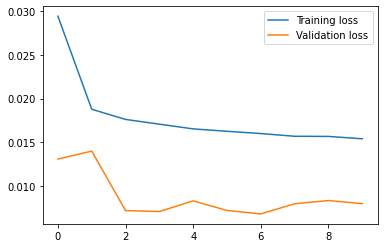

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#Predicting...
n_future = 720
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1H').to_list()

forecast_period_dates[:5]

[Timestamp('2022-03-01 23:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2022-03-02 00:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2022-03-02 01:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2022-03-02 02:00:00+0000', tz='UTC', freq='H'),
 Timestamp('2022-03-02 03:00:00+0000', tz='UTC', freq='H')]

In [ ]:
#Make prediction
prediction = model.predict(trainX[-n_future:]) #shape = (n, 1) where n is the n_days_for_prediction

In [ ]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [ ]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Temp':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df_forecast.head()

,Date,Temp
0,2022-03-01,7.488673
1,2022-03-02,6.564696
2,2022-03-02,6.712876
3,2022-03-02,6.403442
4,2022-03-02,6.091170


In [ ]:
train_dates.head()

0   2008-01-01 00:00:00+00:00
1   2008-01-01 01:00:00+00:00
2   2008-01-01 02:00:00+00:00
3   2008-01-01 03:00:00+00:00
4   2008-01-01 04:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]

In [ ]:
df1.head()

,Date,temp,feels_like,temp_min,temp_max,pressure,wind_speed,weather_main
0,2008-01-01 00:00:00 +0000,7.38,5.53,6.04,8.21,1026,2.76,Clouds
1,2008-01-01 01:00:00 +0000,6.49,4.51,6.04,7.13,1026,2.70,Clouds
2,2008-01-01 02:00:00 +0000,6.45,4.54,5.94,7.06,1025,2.60,Clouds
3,2008-01-01 03:00:00 +0000,6.74,5.05,5.04,7.25,1025,2.39,Clouds
4,2008-01-01 04:00:00 +0000,6.64,5.08,5.59,7.21,1024,2.22,Clouds


In [ ]:
original = df1[['Date', 'temp']]
original['Date']=pd.to_datetime(original['Date'], utc=True)
original = original.loc[original['Date'] >= '2022-01-01 23:00:00 +0000']

original.tail()

<ipython-input-24-52788b3bc6ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'], utc=True)


,Date,temp
124171,2022-03-01 19:00:00+00:00,6.67
124172,2022-03-01 20:00:00+00:00,6.30
124173,2022-03-01 21:00:00+00:00,6.10
124174,2022-03-01 22:00:00+00:00,5.87
124175,2022-03-01 23:00:00+00:00,5.63


In [ ]:
sns.lineplot(original['Date'], original['temp'])
sns.lineplot(df_forecast['Date'], df_forecast['Temp'])